Oftern, we predict one variable with timeseries, however in many cases, multivariable forestcast present more challenge. This notebook illustrates the approach presented in [Multivariate timeseries with SARIMAX](http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels). 

This notebook illustrate how to use **grangercausalitytests** to test hypothesis that one time series will lead to performance other timeseries. Further example can see at the Kaggle challenge:**Two Sigma: Using News to Predict Stock Movements** · 


### The Mechanics of ARIMAX   

In fact in StatsModels library, ARIMAX and ARIMA do not differ. By trying to combine two time-series in a regression opens up to all kinds of new mistakes that analysis can make due to univariate time-series analysis focuses on data stationary while multivariate time-series may contain some interact and/or dependent between variable.   

Based on [author](http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels), the rules are described:

* A cause can generate an effect at the same time that the cause happens. (Things can happen contemporaneously.)  
* A cause can generate an effect that happens after the cause. (The present can affect the future.)  
* A cause that has already happened can generate an affect in the future. (The past can affect the future)
* An effect cannot precede a cause. (The future does not affect the present nor the past.)  
* Speeding weasels can not go faster than the speed of light. (If going faster than the speed of light is possible, all of these rules will cease to exist.)  

These rules of causality form the basis of why ARIMAX deserves to be designated separately from ARIMA. If you violate any of these rules with your ARIMAX model, it automatically invalidates that model.   

Let’s say that you have a **variable X** which **causes Y** with a **1 period lag**. In other words, X happens, and then 1 period later Y happens because of X.   

For concreteness, let’s say the number of Republican Congressman elected in a year is X, and the number of tax cut bills passed by congress is Y. We’ll just assume for now that there is a pretty stable positive relationship between these variables, I don’t know if there is or not, that is for political scientists to figure out. Obviously, a Republican would need to be elected before they could influence the number of tax cuts they give out. But what if we got it wrong. **What if we regressed X on the lag of Y**. We literally just put the cart in front of the horse.   

That would imply that tax cuts cause republicans to get elected. We violated rule 4 or rule 5. That just won’t do.

In general, there is no way to avoid this situation except to use your intuition. However, there does exist a test, which can help you to identify whether or not you are making this mistake

### Another Issue   

So the other problem is there is no way to create a stationary time-series by adding up non-stationary time-series, sort of, there is a special case which would be fun to take a look at called cointegration. We’ll build up to that. For now, if I have a stationary time-series Y, and I regress it on a non-stationary time series, the math will let you do this, you end up with a contradiction. The math is forced to do some weird stuff to make it work out. In fact, your **X variable must be cointegrated with your residuals**. Uh-oh! That means that Y must be a linear combination of noise and X. Things, just got heteroscadastic, serial correlated, and biased. Biased? Really? Why?


It got biased because **in order for X and the residuals to be cointegrated**, the residuals have to be trending, which means that they can not have an expected value of zero. Therefore, the standard proofs that OLS is not biased don’t work, because they depend on the residuals having a mean of zero. So we have to make sure that our X is also stationary.



In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv('./Downloads/data/salesdata2.csv')
print(df)

    Month    Marketing         Sales
0       1   107.284347    123.819229
1       2   214.523447    267.318463
2       3   327.159934    482.107206
3       4   437.384597    762.756909
4       5   518.389038    997.734857
..    ...          ...           ...
70     71  7589.918654   8529.339522
71     72  7771.809813  16866.334206
72     73  7840.068364  14860.740486
73     74  8022.535129  13465.360325
74     75  7809.123841   8801.807069

[75 rows x 3 columns]


We don’t really care about the month variable. So let’s see what these variables look like as time series. We’ll use the following commands to visually inspect these variables.

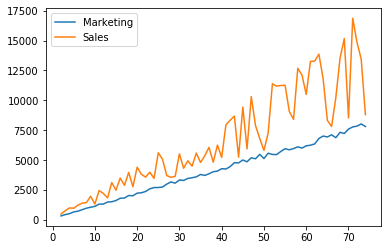

In [15]:
df[['Marketing','Sales']].plot()
plt.show()

First, notice that Sales is more volatile than Marketing. 
With this you can clearly tell that both time-series are trending which is a fairly clear sign that both series have unit roots. We can check whether or not they have unit roots by using the augmented Dickey Fuller (ADF) test. 

In [25]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
print(adfuller(df['Marketing']))

(0.15053951830206763, 0.9693470104299933, 1, 71, {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}, 765.1156349268465)


In [17]:
print(adfuller(df['Sales']))

(-0.4481759584467904, 0.9017390782393213, 11, 61, {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}, 1084.1974686602475)


Clearly, we fail to reject the null-hypothesis that these series have a unit root. So we should difference both series as a first step.

But let’s just run a naive regression to see what happens on the undifferenced time-series, and then again on the differenced time-series, here’s the code for the first regression.

In [21]:
type(df['Sales'])

pandas.core.series.Series

In [22]:
from statsmodels.regression.linear_model import OLS
df['const']=1  
model1= OLS(df['Sales'] , df[['Marketing','const']])
results1=model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     364.7
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           1.10e-29
Time:                        14:40:12   Log-Likelihood:                -645.15
No. Observations:                  73   AIC:                             1294.
Df Residuals:                      71   BIC:                             1299.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Marketing      1.7075      0.089     19.096      0.0

For a differenced time-series regression.

In [24]:
df['diffS']=df['Sales'].diff()
df['diffM']=df['Marketing'].diff()
model2=OLS(endog=df['diffS'].dropna(),exog=df[['diffM','const']].dropna())
results2=model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  diffS   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.632
Date:                Fri, 17 Apr 2020   Prob (F-statistic):              0.109
Time:                        14:47:40   Log-Likelihood:                -653.87
No. Observations:                  72   AIC:                             1312.
Df Residuals:                      70   BIC:                             1316.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
diffM          2.6100      1.609      1.622      0.1

Clearly, there is a difference between these two models. One is just plain wrong. Well, let’s think about this logically for a moment. We get a better fit with the first regression, but when we think about what is going on here, we can remember that both time series are trending. There is a third variable in the mix. Essentially, time is correlated to both my input and output. What happens is that we get a very significant, and wrong, estimate because our coefficient is the ratio of the trends, not the effect that X has on Y. That’s why we get the multicollinearity warning too.     

that must mean that the first is wrong, and the second is right. But there isn’t anything significant in the second, we can’t say anything.

Well, what if we didn’t difference marketing, but we did difference sales? Well, that leads to a consistency problem, we have a series without the unit-root regressed on a series with a unit-root, and that causes the problems with error terms that have to have a trend.   

How is it that I know that Marketing is driving sales and not vice-versa. That’s what a **granger-causality test** is for. The test is whether the first variable is caused by the second variable. Here’s the code:

In [29]:

print(grangercausalitytests(df[['Sales','Marketing']].dropna(),maxlag=1, verbose= True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=32.0475 , p=0.0000  , df_denom=69, df_num=1
ssr based chi2 test:   chi2=33.4409 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4669 , p=0.0000  , df=1
parameter F test:         F=32.0475 , p=0.0000  , df_denom=69, df_num=1
{1: ({'ssr_ftest': (32.047546989343076, 3.17792417270595e-07, 69.0, 1), 'ssr_chi2test': (33.44091859757538, 7.346199734234617e-09, 1), 'lrtest': (27.466895789346836, 1.598066209292297e-07, 1), 'params_ftest': (32.0475469893434, 3.1779241727055833e-07, 69.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1a2507c490>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1a2507c510>, array([[0., 1., 0.]])])}


We can see with lag =1, p < 0.05, we reject the hypothesis that Sales cause Marketing.
You can also see by reversing the test that Sales does not cause Marketing

In [27]:
print(grangercausalitytests(df[['Marketing', 'Sales']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2991  , p=0.5862  , df_denom=69, df_num=1
ssr based chi2 test:   chi2=0.3121  , p=0.5764  , df=1
likelihood ratio test: chi2=0.3114  , p=0.5768  , df=1
parameter F test:         F=0.2991  , p=0.5862  , df_denom=69, df_num=1
{1: ({'ssr_ftest': (0.2990677260990856, 0.5862317779771795, 69.0, 1), 'ssr_chi2test': (0.31207067071208927, 0.5764123100962426, 1), 'lrtest': (0.3113963123232679, 0.5768246136797509, 1), 'params_ftest': (0.2990677260988149, 0.5862317779773486, 69.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1213125d0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1a2508b2d0>, array([[0., 1., 0.]])])}


Here, we fail to reject hypothesis that **Marketing is driven force for the sales**.

Finally, here is the full blown code for the correct ARIMAX model. 

In [14]:
df['lag']=df['diffM'].shift()
df.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=df['Sales'],exog=df[['lag']],order=[1,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   72
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -647.768
Method:                       css-mle   S.D. of innovations           1951.172
Date:                Fri, 17 Apr 2020   AIC                           1303.535
Time:                        12:55:50   BIC                           1312.642
Sample:                             1   HQIC                          1307.161
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           454.1114    266.813      1.702      0.089     -68.833     977.056
lag              -2.9442      1.977     -1.489      0.137      -6.820       0.931
ar.L1.D.Sales    -0.4596      0.113     

/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
